In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler

# for stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# for performance metrics
from sklearn.metrics import mean_squared_error
tf.__version__

'2.4.1'

In [ ]:
df = pd.read_csv('/content/AAPL.csv')

In [ ]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-04-06 00:00:00+00:00,126.210,127.13,125.65,126.50,80171253,126.210,127.13,125.65,126.50,80171253,0.0,1.0
1253,AAPL,2021-04-07 00:00:00+00:00,127.900,127.92,125.14,125.83,83466716,127.900,127.92,125.14,125.83,83466716,0.0,1.0
1254,AAPL,2021-04-08 00:00:00+00:00,130.360,130.39,128.52,128.95,88844591,130.360,130.39,128.52,128.95,88844591,0.0,1.0
1255,AAPL,2021-04-09 00:00:00+00:00,132.995,133.04,129.47,129.80,106686703,132.995,133.04,129.47,129.80,106686703,0.0,1.0
1256,AAPL,2021-04-12 00:00:00+00:00,131.240,132.85,130.63,132.52,91419983,131.240,132.85,130.63,132.52,91419983,0.0,1.0


In [ ]:
df1 = df.reset_index()['close']
df1.shape

(1257,)

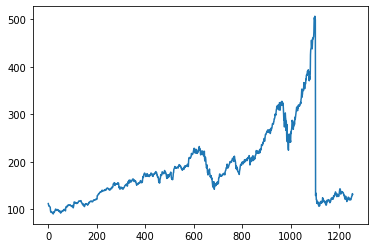

In [ ]:
plt.plot(df1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(1257, 1)

In [ ]:
print(df1) # all value between 0 and 1

[[0.05233915]
 [0.04692724]
 [0.0412267 ]
 ...
 [0.09625977]
 [0.10259771]
 [0.09837643]]


In [ ]:
# Spliting dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size: len(df1), :1]

In [ ]:
train_data.shape, test_data.shape

((817, 1), (440, 1))

In [ ]:
#convert and array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X = t, t+1, t+2, t+3 and Y=t+4
time_steps = 100
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [ ]:
train_data.shape, X_train.shape, y_train.shape

((817, 1), (716, 100), (716,))

In [ ]:
test_data.shape, X_test.shape, y_test.shape

((440, 1), (339, 100), (339,))

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape, X_test.shape

((716, 100, 1), (339, 100, 1))

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 319ms/step - loss: 0.0180 - val_loss: 0.0569
Epoch 2/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0036 - val_loss: 0.0274
Epoch 3/100
12/12 [==============================] - 2s 206ms/step - loss: 0.0019 - val_loss: 0.0281
Epoch 4/100
12/12 [==============================] - 2s 205ms/step - loss: 9.1743e-04 - val_loss: 0.0213
Epoch 5/100
12/12 [==============================] - 2s 210ms/step - loss: 5.0563e-04 - val_loss: 0.0197
Epoch 6/100
12/12 [==============================] - 2s 206ms/step - loss: 3.9945e-04 - val_loss: 0.0191
Epoch 7/100
12/12 [==============================] - 2s 207ms/step - loss: 3.7928e-04 - val_loss: 0.0185
Epoch 8/100
12/12 [==============================] - 2s 207ms/step - loss: 3.9783e-04 - val_loss: 0.0181
Epoch 9/100
12/12 [==============================] - 3s 211ms/step - loss: 3.3821e-04 - val_loss: 0.0178
Epoch 10/100
12/12 [==============================] - 2s 207ms/step

In [ ]:
# let's do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
# transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# calculate RMSE performacne metrics
math.sqrt(mean_squared_error(y_train, train_predict))

165.79074624326537

In [ ]:
# test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

236.37473657769831

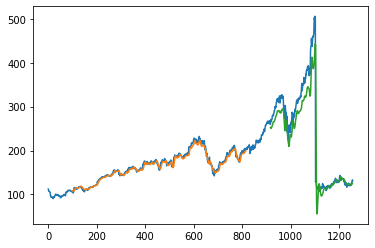

In [ ]:
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

440

In [ ]:
x_input = test_data[340:].reshape(1, -1)
x_input.shape

(1, 100)

In [ ]:
# converted x_input from numpy array to list object
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 30 days
lst_output = []
n_steps = 100
i = 0
while(i<30):
    
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print("\n{} day input:\n{}".format(i+1, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("\n{} day output: {}".format(i+1, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print("\nyhat[0]: ", yhat[0])
        temp_input.extend(yhat[0].tolist())
        print("\nlen(temp_input): ", len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

print("\nOutput for 30 days: \n", lst_output)


yhat[0]:  [0.09147779]

len(temp_input):  101

2 day input:
[0.06987372 0.06660253 0.06806975 0.06494287 0.05654841 0.05972339
 0.06179194 0.06313891 0.06905592 0.07788334 0.07874925 0.07841251
 0.07675286 0.08036079 0.08187613 0.07562237 0.0791341  0.0771377
 0.07562237 0.09029465 0.09012628 0.09226699 0.08734817 0.0911365
 0.09991581 0.09770295 0.10013229 0.11148527 0.10710764 0.10434155
 0.1018641  0.09397474 0.09782321 0.08721587 0.09760673 0.10032471
 0.09294047 0.09250752 0.09753458 0.0927721  0.08851473 0.09017438
 0.10027661 0.11191822 0.11720986 0.12647023 0.1270475  0.12440168
 0.11244738 0.10010824 0.10535177 0.10739627 0.10487072 0.11316897
 0.11165364 0.11201443 0.10984967 0.10835839 0.10773301 0.10831028
 0.10306675 0.09741431 0.09469633 0.09508118 0.0857727  0.08543596
 0.08420926 0.07372219 0.07437162 0.09007817 0.08365604 0.07629585
 0.07165364 0.07475646 0.06258569 0.07395069 0.07129284 0.07605532
 0.0738184  0.08093806 0.08473842 0.08279014 0.07261575 0.0713169
 0.0

In [ ]:
x_input.shape

(1, 100, 1)

In [ ]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [ ]:
len(df1)

1257

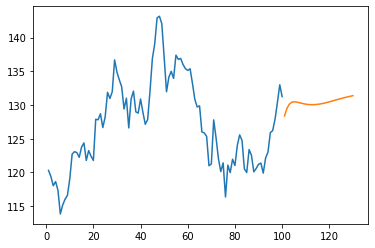

In [ ]:
plt.plot(day_new, scaler.inverse_transform(df1[1157:])) #took data from 1157 since length df1 is 1257
plt.plot(day_pred, scaler.inverse_transform(lst_output))

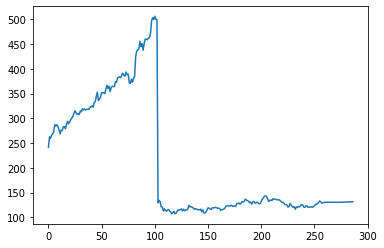

In [ ]:
df3 = df1.tolist()
df3.extend(lst_output)
plt.plot(scaler.inverse_transform(df3[1000:]))